># Homework 1: Machine Learning for Public Policy
##                Exploring  311 Calls Data in Chicago
### Elena Badillo Goicoechea
#### April, 3, 2018

## Introduction

The main goal of this  analysis is to use public data about 311 request calls from the Chicago Open Data Portal to better understand what type of requests come from what type of neighborhoods in the city. <br> We will be using all available data for 2017 for three types of requests from citizens to the city: graffiti removal, lights out in alleys, and abadoned/vacant buildings. These datasets contain, for each request, its creation (and completion, if available) date, subtype, street address, spatial coordinates, and other features. We will eventually augment this datasets with demographic variables at the neighboorhod level.

In [180]:
%matplotlib inline
import sys
import time
import pickle
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import csv
import util

## Problem 1: Data Acquisition and Analysis 

### 1.1 Data Collection and Cleaning

Read the datasets from a previously downloaded csv file:

In [183]:
df_alley = pd.read_csv('311_Alley_Lights.csv')
df_graf1 = pd.read_csv('311_Graffiti_Removal.csv')
df_graf2 = pd.read_csv('311_Graffiti_Removal_2.csv')
df_build = pd.read_csv('311_Vacant_and_Abandoned_Buildings.csv')
df_graf = df_graf1.append(df_graf2) # this has to be done in two parts (the dataset for 2017
# is too large to be downloaded at once)

Get the mapping between community area numbers and names:

In [184]:
ca_map = util.get_ca_map('ca_map.csv')

Remove rows corresponding to requests marked as 'Duplicate' from the alley and grafitti datasets, and then add a Type column:

In [185]:
df_alley = df_alley[df_alley.Status.str.contains("Dup") == False]
df_graf = df_graf[df_graf.Status.str.contains("Dup") == False]
df_build['Type'] = 'Building'
df_alley['Type'] = 'Lights'
df_graf['Type'] = 'Grafitti'

Concatenate street number, name, and direction in the vacant buildings dataset:

In [186]:
df_build['Street Address'] = df_build['ADDRESS STREET NUMBER'].apply(str) +" " \
 + df_build['ADDRESS STREET DIRECTION'] + " " + df_build['ADDRESS STREET NAME'] +" " + df_build['ADDRESS STREET SUFFIX']
df_build = df_build.drop(['ADDRESS STREET NUMBER', 'ADDRESS STREET NAME', 'ADDRESS STREET SUFFIX',\
                          'ADDRESS STREET DIRECTION' ], axis=1)

Homogeneize common column names in order to concatenate the three dataframes:

In [187]:
df_graf.rename(columns = {'Creation Date':'Creation_Date', 'ZIP Code':'ZIP_Code',\
                          'What Type of Surface is the Graffiti on?':'Surface'}, inplace = True)
df_alley.rename(columns = {'Creation Date':'Creation_Date', 'ZIP Code':'ZIP_Code'}, inplace = True)
df_build.rename(columns = {'DATE SERVICE REQUEST WAS RECEIVED':'Creation_Date', 'ZIP CODE':'ZIP_Code',\
                           'X COORDINATE':'X Coordinate', 'Y COORDINATE':'Y Coordinate', 'LATITUDE': 'Latitude', \
                           'LONGITUDE': 'Longitude' , 'SERVICE REQUEST TYPE':'Type of Service Request' ,
       'SERVICE REQUEST NUMBER':'Service Request Number'}, inplace = True)

Add a column for request subtype for grafitti removal requests:

In [188]:
label_map_graf= list(set(df_graf['Surface']))
map_graf = {}
for lab in label_map_graf:
    if lab != 'Cement (Sidewalk, Alley, Wall, Curb)':
        map_graf[lab] =  lab
    else:
        map_graf[lab] = 'Cement'

df_graf['Surface']= df_graf['Surface'].map(map_graf)

Add month and response time columns (note that the building dataset does not report date of completion):

In [189]:
df_alley = util.add_mnth_and_resp(df_alley, date_comp_label= 'Completion Date')
df_graf = util.add_mnth_and_resp(df_graf, date_comp_label= 'Completion Date')
df_build = util.add_mnth_and_resp(df_build)

Finally, concatenate the three dataframes by common columns and add community area names:

In [190]:
dfs = [df_alley, df_graf, df_build]
common_cols = list(set.intersection(*(set(df.columns) for df in dfs)))
df = pd.concat([df[common_cols] for df in dfs], ignore_index=True)
df['Neighborhood']= df['Community Area'].map(ca_map)

This leaves us with a total of 126, 955 requests and 17 features coming from either of the three types, over 2017, once we removed duplicate requests.

In [192]:
df.shape

(126955, 17)

In [193]:
df.head()

,Type of Service Request,Type,Month_Req,Latitude,Y Coordinate,Community Area,Longitude,Service Request Number,Response_Time,X Coordinate,Street Address,Creation_Date,Ward,ZIP_Code,Police District,Location,Neighborhood
0,Alley Light Out,Lights,2017-01-01,41.910797,1.910732e+06,24.0,-87.694558,17-00012051,5.0,1.158120e+06,1630 N WASHTENAW AVE,2017-01-01,1.0,60647.0,14.0,"(41.910797020700905, -87.69455755796577)",WEST TOWN
1,Alley Light Out,Lights,2017-01-01,41.967956,1.931446e+06,11.0,-87.753551,17-00012110,33.0,1.141922e+06,5022 W LAWRENCE AVE,2017-01-01,45.0,60630.0,16.0,"(41.967955764514905, -87.7535510656125)",JEFFERSON PARK
2,Alley Light Out,Lights,2017-01-01,41.912326,1.911103e+06,25.0,-87.793668,17-00007556,36.0,1.131139e+06,1780 N RUTHERFORD AVE,2017-01-01,29.0,60707.0,25.0,"(41.912325756757156, -87.79366844331537)",AUSTIN
3,Alley Light Out,Lights,2017-01-01,41.814199,1.875736e+06,39.0,-87.600576,17-00000532,73.0,1.184002e+06,4447 S BERKELEY AVE,2017-01-01,4.0,60653.0,2.0,"(41.81419884718552, -87.60057625490946)",KENWOOD
4,Alley Light Out,Lights,2017-01-01,41.750317,1.852311e+06,71.0,-87.666530,17-00000761,155.0,1.166203e+06,1717 W 79TH ST,2017-01-01,17.0,60620.0,6.0,"(41.7503167852096, -87.66653004645131)",AUBURN GRESHAM


### 1.2 Basic Exploratory Analysis

Looking at the total number of requests by type for 2017, we can quickly notice that the great majority correspond to grafitti removal requests:

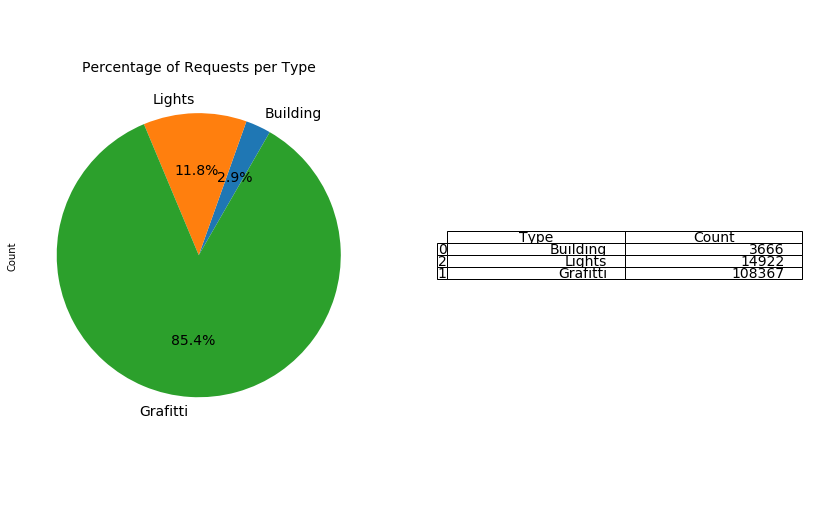

In [243]:
df_by_type = pd.DataFrame({'Count' : df.groupby(['Type']).size()})\
.reset_index().sort_values(by='Count')

plt.figure(figsize=(14,9))
ax1 = plt.subplot(121, aspect='equal')
df_by_type['Count'].plot.pie(startangle=60, autopct='%1.1f%%', \
          labels = ["Building",'Lights', "Grafitti"],ax=ax1, fontsize=14)
plt.title("Percentage of Requests per Type", fontsize=14)

ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, df_by_type, loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(14)
plt.show()

Even if the type composition of the total number of requests is _somewhat_ steady over time, we can notice a __seasonal trend__. Namely, there tend to be relatively more grafitti complaints during summer and winter (probably related to vacation times). Yet the other two types are not as seasonal, so the time trend seems mainly driven by the amount of grafitti requests, as seen in the plot below:

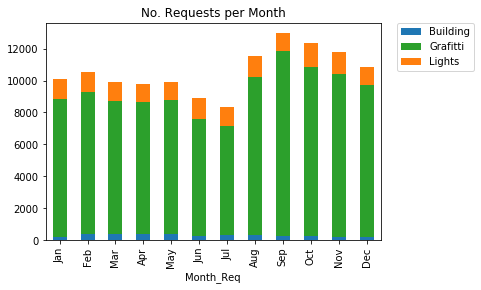

In [242]:
df_by_typ_mnth = pd.DataFrame({'Count' : df.groupby(['Month_Req', 'Type']).size()}).reset_index()
df_piv = df_by_typ_mnth.pivot(index='Month_Req', columns='Type', values='Count')
labels=['Jan','Feb','Mar','Apr','May', 'Jun','Jul','Aug','Sep','Oct','Nov','Dec']
fig, ax = plt.subplots()
fig.canvas.draw()
df_piv.plot(kind='bar', stacked=True, color= ['#1f77b4','#2ca02c','#ff7f0e'], ax=ax)
ax.set_xticklabels(labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("No. Requests per Month")

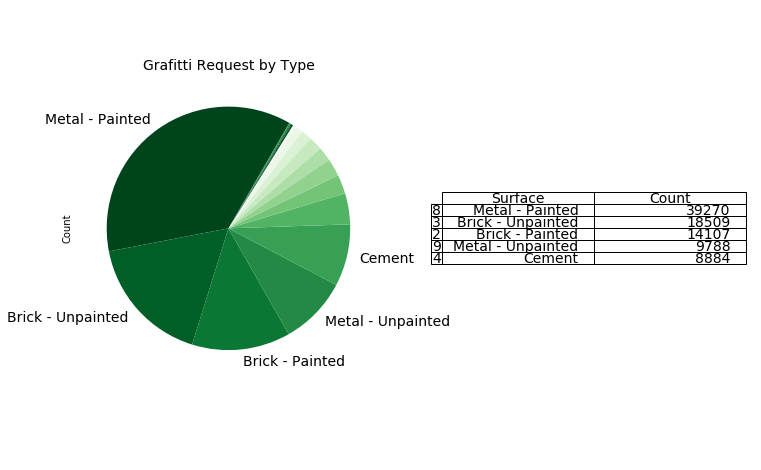

In [234]:
df_subtype = pd.DataFrame({'Count' : df_graf.groupby(['Surface']).size()})\
.reset_index().sort_values(by='Count', ascending=False)

TOP_SUBTYPES= [df_subtype['Surface'][i] for i in range(len(df_subtype)) if df_subtype['Count'][i] > 8000]
labels =[x if x in TOP_SUBTYPES else '' for x in list(df_subtype['Surface']) ]
colors = plt.cm.Greens(np.linspace(1, 0, 13))

plt.figure(figsize=(12,8))
ax1 = plt.subplot(121, aspect='equal')
df_subtype['Count'].plot.pie(startangle=60, autopct='',ax=ax1, labels=labels, fontsize=14, colors = colors)
plt.title("Grafitti Request by Type", fontsize=14)

ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, df_subtype.head(5), loc='center')
tbl.set_fontsize(14)
plt.show()

Next question: Where are the request coming from? We can look at the overall frequency gruoped by community area:

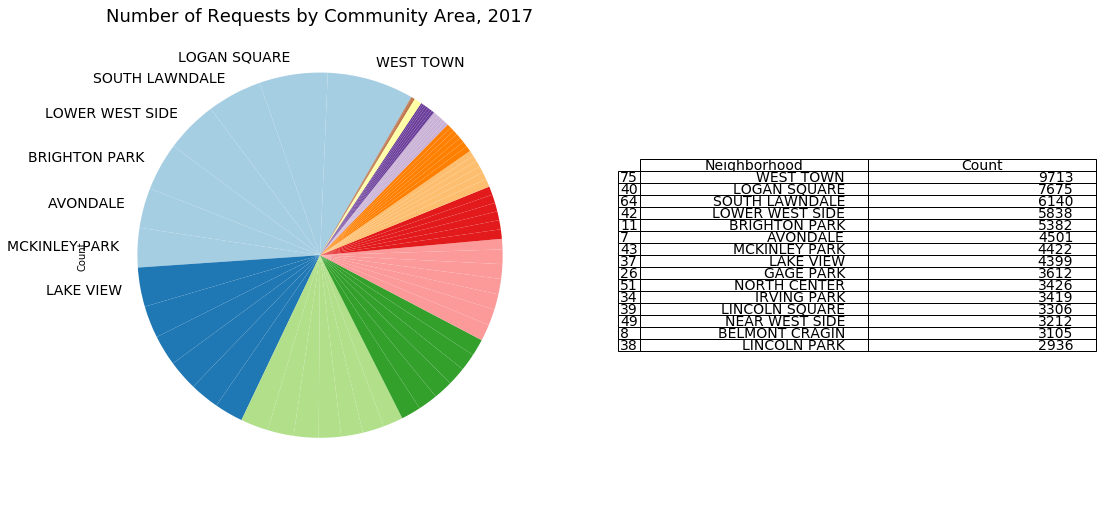

In [238]:
df_by_neigh = pd.DataFrame({'Count' : df.groupby(['Neighborhood']).size()})\
.reset_index().sort_values(by='Count', ascending=False)

TOP_AREAS= [df_by_neigh['Neighborhood'][i] for i in range(len(df_by_neigh)) if df_by_neigh['Count'][i] > 4000]
labels =[x if x in TOP_AREAS else '' for x in list(df_by_neigh['Neighborhood']) ]
colors = plt.cm.Paired(np.linspace(0, 1, 78))

plt.figure(figsize=(18,9))
ax1 = plt.subplot(121, aspect='equal')
df_by_neigh['Count'].plot.pie(startangle=60,ax=ax1, labels=labels,fontsize =14, colors=colors)
plt.title("Number of Requests by Community Area, 2017", fontsize =18)
ax2 = plt.subplot(122)
plt.axis('off')
tbl = table(ax2, df_by_neigh.head(15), loc='center')
tbl.set_fontsize(14)
plt.show()

The above might not very informative, but it hints to us that the spatial distribution of requests is not even close to uniform, as most of them come from less than 20 community areas.

Next question: what type of requests are these top areas making?

In [154]:
df_by_nt = pd.DataFrame({'% Of Total Requests' : df.groupby(['Neighborhood', 'Type']).size()}).sort_values(by='% Of Total Requests', ascending=False)
df_by_nt_per = df_by_nt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df_by_nt_per.head(20) # by neighborhood and type

,,% Of Total Requests
Neighborhood,Type,
WEST TOWN,Grafitti,96.005354
LOGAN SQUARE,Grafitti,95.674267
SOUTH LAWNDALE,Grafitti,94.283388
LOWER WEST SIDE,Grafitti,95.649195
BRIGHTON PARK,Grafitti,94.277220
AVONDALE,Grafitti,96.334148
MCKINLEY PARK,Grafitti,96.743555
LAKE VIEW,Grafitti,95.317118
GAGE PARK,Grafitti,94.186047


This might not be very surprising (we saw most requests are about graffiti). But, interestingly, this proportion does not hold for every area in the city:

In [20]:
df_by_nt = pd.DataFrame({'%Total' : df.groupby(['Neighborhood', 'Type']).size()})
df_by_nt_per = df_by_nt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
df_by_nt_per.head(20)

%Total
Neighborhood   Type               
ALBANY PARK    Building   0.286944
               Grafitti  94.010043
               Lights     5.703013
ARCHER HEIGHTS Building   0.088771
               Grafitti  95.517088
               Lights     4.394141
ARMOUR SQUARE  Building   0.628931
               Grafitti  91.666667
               Lights     7.704403
ASHBURN        Building   0.865052
               Grafitti  76.528258
               Lights    22.606690
AUBURN GRESHAM Building  25.248071
               Grafitti  29.437707
               Lights    45.314223
AUSTIN         Building   6.586826
               Grafitti  53.021230
               Lights    40.391943
AVALON PARK    Building  25.842697
               Grafitti   8.426966

The above suggests it might be interesting to take a closer look at the spatial distribution of the service requests:

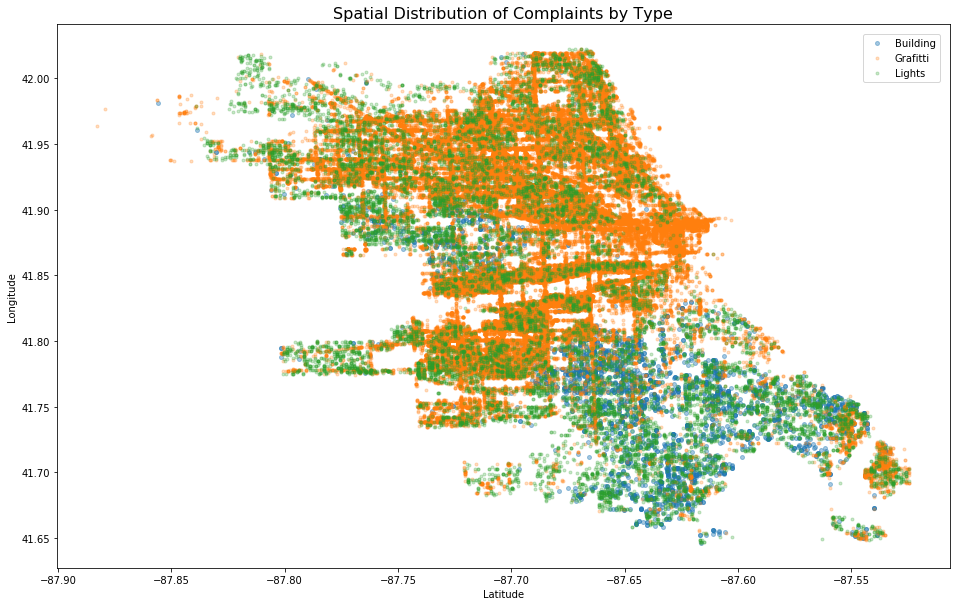

In [148]:
groups = df.groupby('Type')
fig, ax = plt.subplots(figsize=(16, 10))
ax.margins(0.05)
for name, group in groups:
    if name == 'Grafitti':
        ax.plot(group.Longitude, group.Latitude, marker='o', linestyle='', ms=3, \
                label=name, alpha = 0.25)
    elif name == 'Building':
        ax.plot(group.Longitude, group.Latitude, marker='o', linestyle='', ms=4, \
        label=name, alpha = 0.4)
    else:
        ax.plot(group.Longitude, group.Latitude, marker='o', linestyle='', ms=3, \
        label=name, alpha = 0.25)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.legend(fontsize=16)
ax.set_xlabel("Latitude")
ax.set_ylabel("Longitude")
plt.legend(bbox_to_anchor=(1, 1), loc=0, borderaxespad=1.)
plt.title("Spatial Distribution of Complaints by Type", fontsize=16)

The map above depicts a clear spatial clustering among request types. In particular, we can notice that graffiti requests tend to come from the northern parts of the city, abandoned/vacant building requests tend to come from the southern parts, and lights out requests seem more evenly distributed throughout Chicago.

As for the __distribution of response times__ from the city, we can notice a stark difference between grafitti and lights out complaints (we are not including building requests, as their completion dates are not reported). <br> In particular, response times for grafitti are heavily clustered near zero, while lights out complaints tend to take a much longer time to be answered (also, with a much larger variance), as shown below:

In [149]:
df_resp = df[df['Type']!='Building']
df_resp.groupby('Type')['Response_Time'].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
Grafitti,108367.0,0.652653,1.026711,0.0,0.0,0.0,1.0,22.0
Lights,12790.0,44.920797,51.296945,0.0,7.0,27.0,66.0,403.0


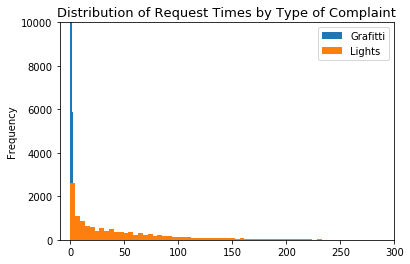

In [155]:
df_resp.groupby('Type')['Response_Time'].plot.hist(bins=90)
plt.ylim((0,10000))
plt.xlim((-10,300))
plt.legend()
plt.title("Distribution of Request Times by Type of Complaint", fontsize=13)

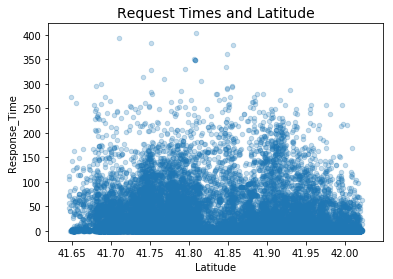

In [151]:
df_resp.plot.scatter('Latitude', 'Response_Time', alpha = 0.25)
plt.title("Request Times and Latitude", fontsize=14)

Request times _seem_ lower, on average, for northern (i.e. higher latitude) areas of Chicago, as noted in the (somewhat fuzzy) scatter above. The correlation between latitude and response time seems to confirm this:

In [152]:
df_resp['Latitude'].corr(df_resp['Response_Time'])

-0.15128617037840675

This correlation, of course, could be reflecting the same fact we saw before: grafitti requests are answered much faster than light out requests, and the former are heavily concentrated in the northern regions of Chicago.

### 1.3 Preliminary Conclusions

A basic exploration of the 311 data yielded some interesting insights about Chicago:
 - Most requests to the 311 are complaints about __grafitti__, which tend to come from the __northern__ areas of the city, and tend to get a very quick response from the city (less than 2 days, on average). This "within" trend seemed to hold over time, throughout 2017. However, we can notice some __overall seasonal fluctuations__ at a monthly-basis: vacational periods are associated with less requests from all types.
 - Most requests come from less than 15 of the 78 community areas in the city.
 - Complaints about abandoned/vacant __buildings__ tend to come from the __southern__ parts of the city, and their response times are not reported in the data.
 - Requests about __lights out__ seem more evenly distributed around the city, but they tend to have much higher __response times__ (more than 50 days, on average) than the rest, and with much higher __variance__. Interestingly, response times for abandoned/vacant buildings are not reported by the city.

## Problem 2: Data Augmentation and APIs 

Using the American Community Survey (ACS) API we can augment our original dataset with some [demographic variables](https://api.census.gov/data/2015/acs1/variables.html) to search for possible patterns suggesting any clustering or correlations between the type and/or frequency of requests and the demographic profile of the zones they are coming from. <br><br> Given that the dataset is large and there are API limits, we will slice it to include just data at the tract (block group) level for November and December 2017, from the three types (which will leave us with about 22,000 observations).

More specifically, for each request, we will use its spatial coordinate (Latitude, Longitude) to query the ACS 2015 with data for the tract corresponding to that location. We will draw requests for the the following variables:
- Race: proportion of __white__ population
- Income: proportion of the population who reported earning an income below __poverty__ level during the last 12 months.
- Education: proportion of the population with a __college__ degree.

Since the data augmentation process is computationally expensive, the functions used to do it are not run in here, so if the reader wishes to explore the data, it might be better to read the following csv:

In [36]:
df_augm = pd.read_csv('df_augm.csv')

In [41]:
df_augm = df_augm.loc[:, 'Creation_Date':]
df_augm.shape

(21548, 20)

Now that we have some useful demographics for the areas where each request came from, we can try to answer some interestings questions. For instance, what are the average levels of white population, poverty and education in the tracts (block groups) that send building, grafitti, and light out requests?

In [156]:
df_av = df_augm.groupby('Type')['Whites'].mean().to_frame()
df_av['Poverty'] = df_augm.groupby('Type')['Poverty'].mean()
df_av['Education'] = df_augm.groupby('Type')['Educ'].mean()
df_av

,Whites,Poverty,Education
Type,,,
Building,0.151099,0.223861,0.079733
Grafitti,0.634615,0.141369,0.266145
Lights,0.449981,0.142789,0.176538


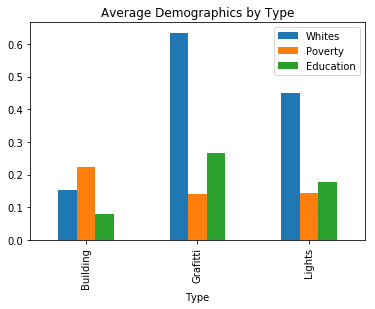

In [157]:
df_av.plot.bar()
plt.title("Average Demographics by Type")

Here we can notice a pattern: grafitti (building) complaints tend to come from whiter (less white), richer (poorer), more (less) educated areas in the city. This relationships become even more evident when looking at the marginal probability densities by type:

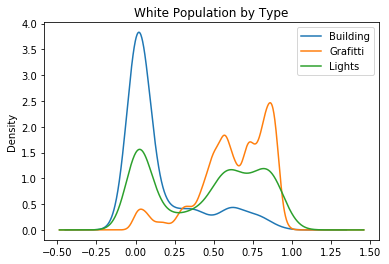

In [68]:
df_augm.groupby('Type')['Whites'].plot.kde() # dens1
plt.legend()
plt.title("White Population by Type")

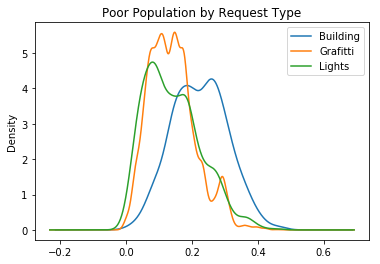

In [69]:
df_augm.groupby('Type')['Poverty'].plot.kde()
plt.legend()
plt.title("Poor Population by Request Type")

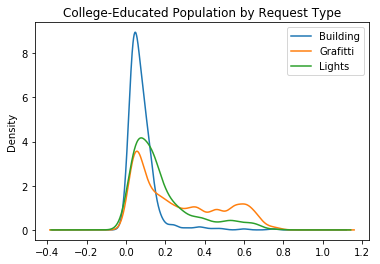

In [70]:
df_augm.groupby('Type')['Educ'].plot.kde()
plt.legend()
plt.title("College-Educated Population by Request Type")

This reveals some __additional interesting features__ about the data. Graffiti requests tend to clearly come from richer, whiter, and more educated areas.<br>
Exactly the opposite happens with the building requests: they clearly tend to come from less white, less educated and poorer areas,<br>
As for the lights out requests, even if it was previously not clear from the data, now we can notice that, like buildings, they tend to come from less educated and poorer areas (albeit not as starkly as graffiti ones). However, their correlation with race is not as clear: the denisity is bimodal (which might help to explain their even spatial distribution, as seen in the previous map of the city).

We can further investigate if __response times__ from the city vary along these demographic variables, which can hopefully help us to explain the uneven spatial distribution of the requests we saw before. <br><br>
First, we can calculate averages at the community area level for response times, education, poverty, and white population:

In [162]:
df_resp_neig = df_augm[df_augm['Type'] != 'Building'].groupby('Neighborhood')['Response_Time'].mean().to_frame()
df_resp_neig['Whites'] = df_augm[df_augm['Type'] != 'Building'].groupby('Neighborhood')['Whites'].mean()
df_resp_neig['Pov'] = df_augm[df_augm['Type'] != 'Building'].groupby('Neighborhood')['Poverty'].mean()
df_resp_neig['Educ'] = df_augm[df_augm['Type'] != 'Building'].groupby('Neighborhood')['Educ'].mean()

In [163]:
df_resp_neig.head(10)

,Response_Time,Whites,Pov,Educ
Neighborhood,,,,
ALBANY PARK,2.035836,0.585072,0.134451,0.206379
ARCHER HEIGHTS,1.632701,0.597570,0.093628,0.058318
ARMOUR SQUARE,0.898734,0.073450,0.309770,0.135118
ASHBURN,6.448819,0.283351,0.077210,0.113278
AUBURN GRESHAM,13.562500,0.007636,0.206783,0.074504
AUSTIN,5.897638,0.118805,0.190528,0.085970
AVALON PARK,23.100000,0.010170,0.171013,0.125083
AVONDALE,0.803815,0.833826,0.152745,0.188407
BELMONT CRAGIN,0.511628,0.499632,0.115900,0.076429


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2b8cfda0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a2e012630>]], dtype=object)

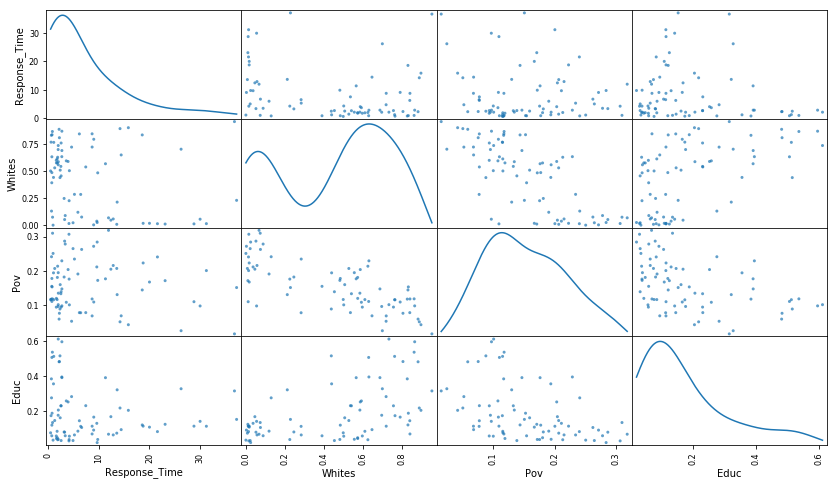

In [145]:
pd.plotting.scatter_matrix(df_resp_neig, alpha = 0.7, figsize = (14,8), diagonal = 'kde')

We can already see some interesting patterns. For instance:
 -  Response time and college education seem heavily skewed towards zero.
 -  White population and response time seem negatively correlated.
 -  College educated areas seem to be associated, on average, with lower response times.
 -  Poverty and % of white population seem negatively correlated, while white population and college education are clearly positively correlated.

A correlation matrix and a corresponding heatmap can help us uncover these __correlations__ in a cleaner way:

In [146]:
corr = df_resp_neig.corr()
corr

,Response_Time,Whites,Pov,Educ
Response_Time,1.000000,-0.264623,-0.130904,-0.138848
Whites,-0.264623,1.000000,-0.729087,0.511487
Pov,-0.130904,-0.729087,1.000000,-0.431382
Educ,-0.138848,0.511487,-0.431382,1.000000


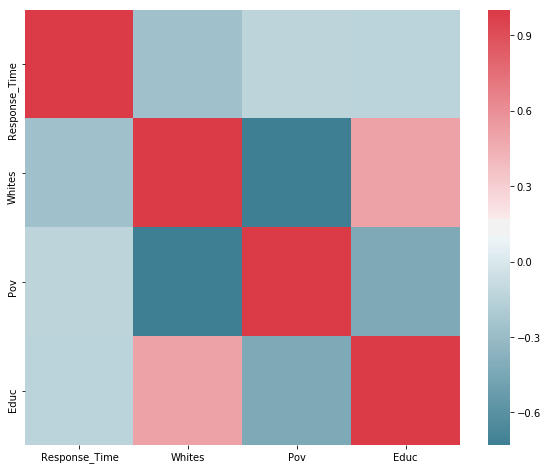

In [147]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

Indeed, the correlation between response times and white population is negative.

We can do this same analysis with latitude, to analyze possible correlations between income, education, and race, against spatial location along the Y axis of the city:

In [127]:
df_lat_neig = df_augm.groupby('Neighborhood')['Latitude'].mean().to_frame()
df_lat_neig['Whites'] = df_augm.groupby('Neighborhood')['Whites'].mean()
df_lat_neig['Pov'] = df_augm.groupby('Neighborhood')['Poverty'].mean()
df_lat_neig['Educ'] = df_augm.groupby('Neighborhood')['Educ'].mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1111ed978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121671eb8>]], dtype=object)

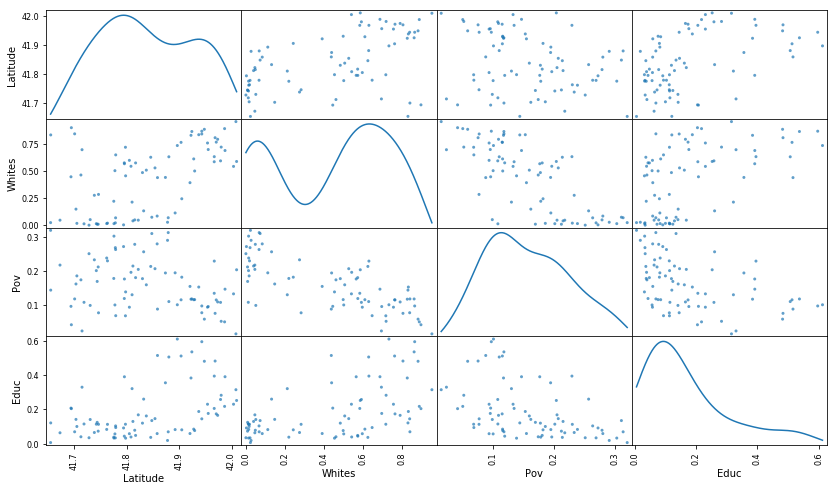

In [122]:
pd.plotting.scatter_matrix(df_lat_neig, alpha = 0.7, figsize = (14,8), diagonal = 'kde')

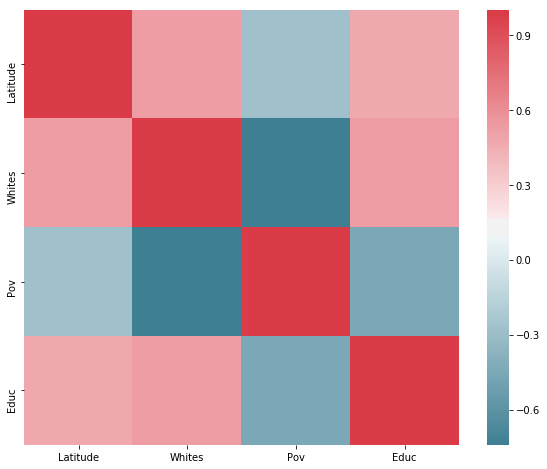

In [128]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_lat_neig.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

We can notice a stark positive correlation between income, education, and white population, against latitude. This means that, indeed, northern areas in Chicago tend to be richer, whiter, and more college-educated than southern regions.

### Conclusions

After analyzing this dataset, we learned the following about the city of Chicago:
 - The city geography is __highly segregated__ in terms of income, education, and race.<br><br>
 - The type of requests coming from each area are also correlated along these demographic margins, which yields a similar spatial segregation among request types.<br><br>
 - In particular, we see a higher proportion of __grafitti__ removal requests coming from __richer, whiter, __and__ more educated__ areas (which in turn, cluster in the __north__ of the city), and, conversely a higher proportion of vacant/abandoned __building__ requests come from the __southern__ (poorer, less white and less educated) parts of the city.<br><br>
 - As for the __lights out__ requests, they seem to be more evenly distributed around the city than the other two. However, conditional densities do suggest that they tend to come from _slightly_ poorer and less educated areas, on average.<br><br>
 - A possible rationale for this pattern could be that 1) people with a higher income are more concerned about "visual pollution" from grafitti prints than poorer people. In contrast, the well-documented process of gentrification in the city during the last few decades and especially after the 2008 housing bubble, yielded a lot of abandoned buildings/condos in the lower-income areas of Chicago, drawing a lot of complaints from these areas about vacancies nowadays.<br><br>
 - The __uneven seasonal trends__ in the number of requests seem to support the above rationale: grafitti calls are typically lower during vacaction times (summer and winter) than in the rest of the year, while lights out and building requests are not as seasonal. We could plausibly think people with higher income tend to leave the city for trips (and/or are less stressed during those times) relative to lower income people.<br><br>
 - __Response times__ from the city for 311 calls are also correlated with request types, which could be explained by the area demographics as well: we see that __request times are radically lower for grafitti__ requests (1-2 days on average and with very low variance) than for lights out requests (about 50 days, on average, and with very high variance), while response times for vacant building requests are not even reported in the City data portal.

## Problem 3

#### Assume you are running the 311 call center for Chicago. You get a call from 3600 W Roosevelt Ave.
     

 - Of the three types of requests you have data for, which request type is the most likely given the call came from 3600 W Roosevelt Ave? What are the probabilities for each type of request? 

_If we look at the whole 311 dataset for the three types (not just for 2017 but for past years, too) there are 4 requests that came from from 3600 W Roosevelt Rd (not Ave., but a 'fuzzy' matching would yield that address). All those calls were about grafitti removal requests so the __probability__ that it is about grafitti, __conditional__ on the fact that the call came from that address, is equal to P(Graf/Add) = P(Graf | Add) / P( __1___.

- Let’s now assume that a call comes in about Graffiti Removal. Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park  vs Uptown? 

In [239]:
df_g = df[df['Type']=='Grafitti']
df_ggarf = df_g[df_g['Neighborhood'].str.contains('GARFIELD')==True]
df_ggupt= df_g[df_g['Neighborhood'].str.contains('UPTOWN')==True]
prob_garf = len(df_ggarf) / len(df_g)
prob_uptown = len(df_ggupt) / len(df_g)
prob_garf, prob_uptown

(0.011055025976542674, 0.016167283398082443)

_The conditional probability that the call came from Garfield park is around __1.10%__, while the conditional probability that it came from Uptown is about __1.61%___. Hence, the likelihood that the call came from Uptown is about __46.2% higher__ than from Garfield Park.

In [240]:
(prob_uptown / prob_garf) - 1

0.46243739565943254

- Now assume that you don’t have access to all the raw data and you know the following things:
  - There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown.
  - Of the 600 calls from Garfield Park, 100 of them are about Graffiti Removal.
  - Of the 400 calls from Uptown, 160 are about Graffiti Removal.

If a call comes about Graffiti Removal, how much more/less likely is it that the call came from Garfield Park versus Uptown? 

_In this case, a total of 260 from all the 1000 calls are about grafitti removal. From those calls,  we know 160 came from Uptown and 100 came from Garfield Park. This means that the likelihood that a grafitti call comes from Garfield Park is __38.46%__ and the likelihood that it came from Uptown is __61.53%___. A 60% higher likelihood.